In [536]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [537]:
def print_image(image, color_space="rgb", title=""):
    if len(image.shape) == 2:
        pixels = np.array(image)
        plt.imshow(pixels, cmap="gray")
    else:
        if color_space == "bgr":
            img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        elif color_space == "hsv":
            img = cv.cvtColor(image, cv.COLOR_HSV2RGB)
        else:
            img = image

        pixels = np.array(img)
        plt.imshow(pixels / 255.0)

    plt.title(title)
    plt.axis('off')
    plt.show()

In [538]:
# all tray images work, except one small coin in tray4 is considered a big coin 
img_path = 'tray8.jpg'

### Contours of a tray first

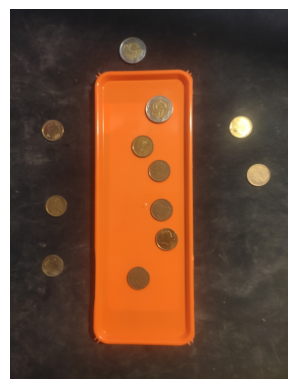

In [539]:
# import image, blur it, and convert to grayscale colorspace
img_original = cv.imread(img_path)
if img_original is None:
    exit('Could not load image')
print_image(img_original, color_space="bgr")

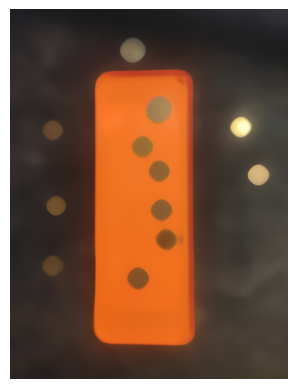

In [540]:
img_blur_for_tray = cv.medianBlur(img_original, 39)
print_image(img_blur_for_tray, color_space="bgr")

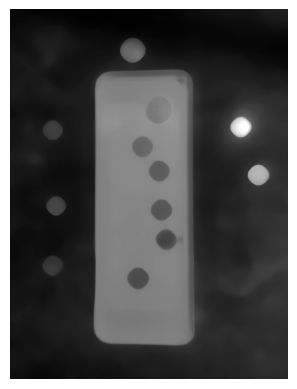

In [541]:
img_gray = cv.cvtColor(img_blur_for_tray, cv.COLOR_BGR2GRAY)
print_image(img_gray)

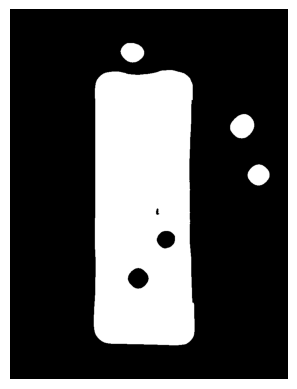

In [542]:
# get binary lvl photo and contours
ret, thresh = cv.threshold(img_gray, 99, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print_image(thresh)

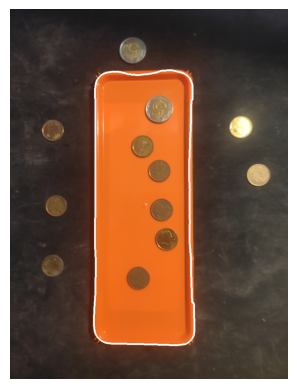

In [543]:
# # find contour of the TRAY - it is contour with the biggest area - using for loop and if condition
imax = 0
area_max = 0
for c in range(len(contours)):
    area_temp = cv.contourArea(contours[c])
    if area_temp > area_max:
        imax = c
        area_max = area_temp
tray = contours[imax]
# where imax is the number of the contour with the biggest area
area = cv.contourArea(tray)
_ = cv.drawContours(img_original, [tray], 0, (255, 255, 255), 3)
print_image(img_original, color_space='bgr')

# Now coins

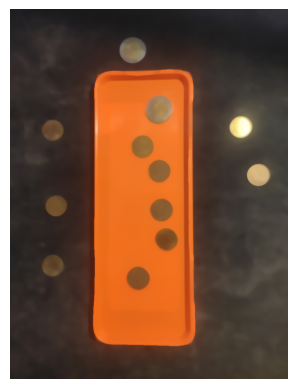

In [544]:
img_blur_for_coins = cv.medianBlur(img_original, 15)
print_image(img_blur_for_coins, color_space="bgr")

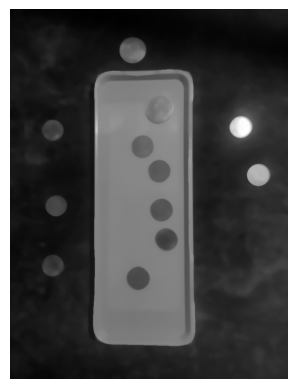

In [545]:
img_gray = cv.cvtColor(img_blur_for_coins, cv.COLOR_BGR2GRAY)
print_image(img_gray)

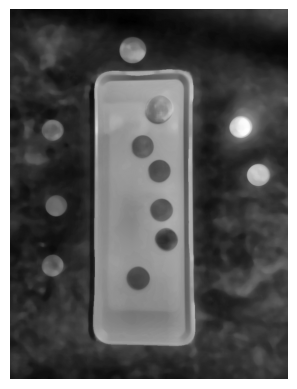

In [546]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_gray)
print_image(img_clahe)

In [547]:
img_final = img_clahe

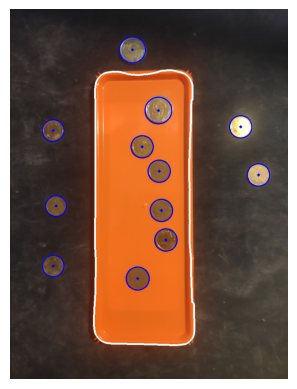

In [548]:
img_temp = img_original.copy()
# find circles
# cv.HOUGH_GRADIENT is an algorithm
# param 1 canny edge detection parameter
# param 2 the higher the value, the less circles are detected

# param 2 at least 31 for tray3
# minRadius at least 25 for tray7
circles = cv.HoughCircles(img_final, cv.HOUGH_GRADIENT, 1, 10, param1=40, param2=31, minRadius=25, maxRadius=37)
circles = np.uint16(np.around(circles))
# draw circles
for c in circles[0, :]:
    # draw the outer circle
    cv.circle(img_temp, (c[0], c[1]), c[2], (255, 0, 0), 2)
    # draw the center of the circle
    cv.circle(img_temp, (c[0], c[1]), 2, (255, 0, 0), 3)

print_image(img_temp, color_space='bgr')

In [549]:
max_radius = np.max(circles[0][:, 2])
max_radius

np.uint16(36)

In [550]:
min_radius = np.min(circles[0][:, 2])
min_radius

np.uint16(28)

In [551]:
mean_radius = (max_radius + min_radius) * 0.5

In [552]:
# calculate coins
big_coins_in_tray = []
small_coins_in_tray = []
big_coins_out_tray = []
small_coins_out_tray = []

for c in circles[0, :]:
    #  inside
    if cv.pointPolygonTest(tray, (c[0], c[1]), False) > -1:
        # bigger
        if c[2] > mean_radius:
            big_coins_in_tray.append(c)
        # smaller
        else:
            small_coins_in_tray.append(c)
    # outside
    else:
        # bigger
        if c[2] > mean_radius:
            big_coins_out_tray.append(c)
        # smaller
        else:
            small_coins_out_tray.append(c)

In [553]:
big_in = len(big_coins_in_tray)
big_out = len(big_coins_out_tray)
small_in = len(small_coins_in_tray)
small_out = len(small_coins_out_tray)

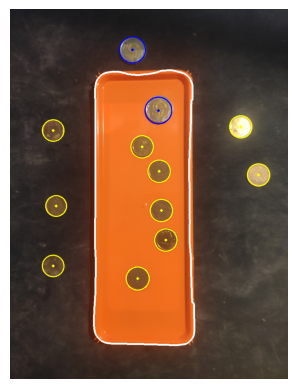

In [554]:
img_circles = img_original.copy()

for c in big_coins_in_tray:
    cv.circle(img_circles, (c[0], c[1]), c[2], (255, 0, 0), 2)
    cv.circle(img_circles, (c[0], c[1]), 2, (255, 0, 0), 3)

for c in big_coins_out_tray:
    cv.circle(img_circles, (c[0], c[1]), c[2], (255, 0, 0), 2)
    cv.circle(img_circles, (c[0], c[1]), 2, (255, 0, 0), 3)

for c in small_coins_in_tray:
    cv.circle(img_circles, (c[0], c[1]), c[2], (0, 255, 255), 2)
    cv.circle(img_circles, (c[0], c[1]), 2, (0, 255, 255), 3)

for c in small_coins_out_tray:
    cv.circle(img_circles, (c[0], c[1]), c[2], (0, 255, 255), 2)
    cv.circle(img_circles, (c[0], c[1]), 2, (0, 255, 255), 3)

print_image(img_circles, color_space='bgr')

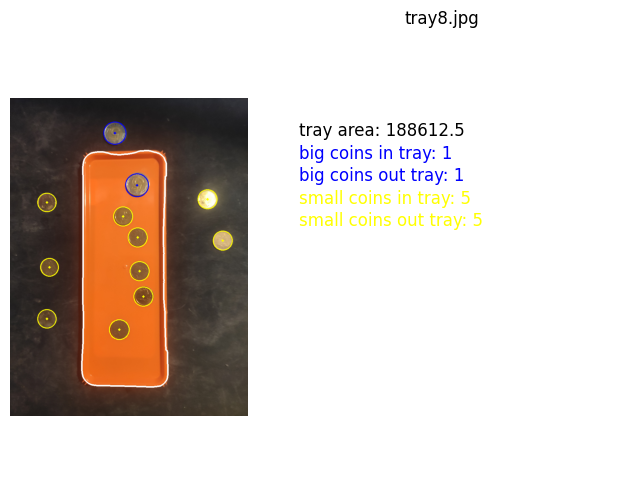

In [555]:
text_lines = [
    f"tray area: {area_max}",
    f"big coins in tray: {big_in}",
    f"big coins out tray: {big_out}",
    f"small coins in tray: {small_in}",
    f"small coins out tray: {small_out}"
]

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1.5]})
ax[0].imshow(cv.cvtColor(img_circles, cv.COLOR_BGR2RGB))
ax[0].axis('off')

y_pos = 0.8
line_spacing = 0.05

for line in text_lines:
    if "big coins" in line:
        color = 'blue'
    elif "small coins" in line:
        color = 'yellow'
    else:
        color = 'black'

    ax[1].text(0.1, y_pos, line, verticalalignment='top', fontsize=12, color=color)
    y_pos -= line_spacing

ax[1].axis('off')
plt.tight_layout()
plt.title(img_path)
plt.show()